In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam
# list paths of train and test datasets  
os.listdir('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset')

['dataset', 'test', 'train']

### Data Augmentation 

In [2]:
TRAIN_PATH = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train"
TEST_PATH = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test"
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
IMG_SHAPE= (224,224)
## train generator 
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                 zoom_range=0.2,
                                 shear_range=0.3,
                                 horizontal_flip=True,
                                 brightness_range=[0.5,1.5])
#test generator 
test_datagen = ImageDataGenerator(rescale=1/255.0)

#generate data from train and test directories 
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")

test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


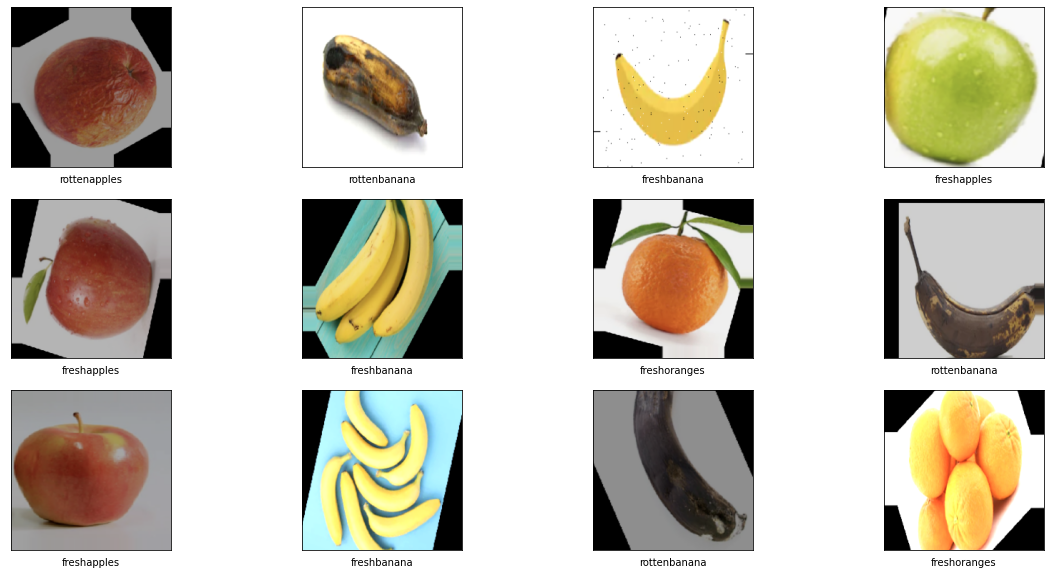

In [3]:
#get classes dict 
classes_dict = dict(test_gen.class_indices)
#reverse 
classes_dict = {v: k for k,v in classes_dict.items()}
#let's plot sone images 
images,labels=train_gen.next()
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes_dict[labels[i]])

### Transfer Learning 

In [6]:
#create Inception Model 
inception = InceptionV3(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
#show the base model summary 
inception.summary()
#show how manay layers in the Resnet Network
layers = inception.layers
print(f'Number of Layers: {len(layers)}')

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### Train InceptionV3 Model

In [8]:
# number of samples for each set 
TRAIN_SIZE = train_gen.samples
TEST_SIZE = test_gen.samples
# early stopping 
callbacks = EarlyStopping(patience = 3, monitor='val_acc')
                        
# let's train our Model 
inputs = inception.input
# get the output of inception NN and add an average pooling layer
x = inception.output
x = GlobalAveragePooling2D()(x)
# add the a dense layer
x = Dense(512, activation='relu')(x)
# add a dropout 
x = Dropout(0.5)(x)
# finally, add an output layer
outputs = Dense(6, activation ='softmax')(x)
# build the model to train 
model = Model(inputs=inputs, outputs=outputs)

# freeze all convolutional inception layers
for layer in layers:
    layer.trainable = False

# compile the model 
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train the model for 10 epochs 
history = model.fit_generator(
                train_gen,
                epochs= EPOCHS,
                validation_data = test_gen,
                validation_steps = TEST_SIZE//BATCH_SIZE,
                steps_per_epoch = TRAIN_SIZE//BATCH_SIZE,
                callbacks = [callbacks])

Epoch 1/5
340/340 [==============================] - 222s 641ms/step - loss: 0.2918 - accuracy: 0.8995 - val_loss: 0.0873 - val_accuracy: 0.9661
Epoch 2/5
340/340 [==============================] - 179s 527ms/step - loss: 0.1382 - accuracy: 0.9507 - val_loss: 0.0736 - val_accuracy: 0.9725
Epoch 3/5
340/340 [==============================] - 178s 524ms/step - loss: 0.1139 - accuracy: 0.9567 - val_loss: 0.0541 - val_accuracy: 0.9825
Epoch 4/5
340/340 [==============================] - 181s 531ms/step - loss: 0.1012 - accuracy: 0.9633 - val_loss: 0.0653 - val_accuracy: 0.9762
Epoch 5/5
340/340 [==============================] - 178s 524ms/step - loss: 0.0937 - accuracy: 0.9659 - val_loss: 0.0393 - val_accuracy: 0.9874


### Model Evaluation

Text(0.5, 0, 'N.of Epochs')

<Figure size 432x288 with 0 Axes>

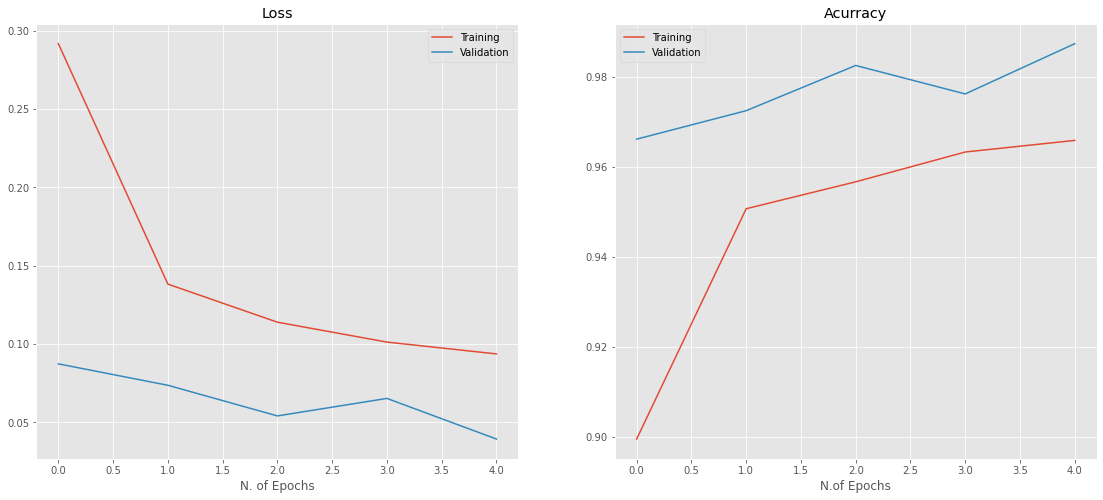

In [9]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

In [10]:
#Evaluate
loss, test_acc = model.evaluate(test_gen)
print("Validation Accuracy = %f \nValidation Loss = %f " % (test_acc, loss))

85/85 [==============================] - 17s 193ms/step - loss: 0.0397 - accuracy: 0.9870
Validation Accuracy = 0.987027 
Validation Loss = 0.039665 


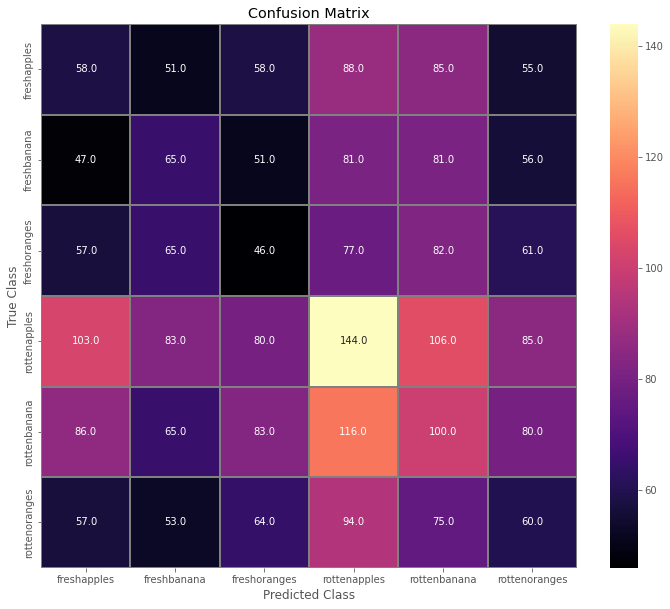

In [11]:
class_names = list(classes_dict.values())
labels = test_gen.classes
preds =  model.predict(test_gen)
predictions = np.argmax(preds, axis=1)
#show the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions) 
# plot the confusion matrix
fig,ax = plt.subplots(figsize=(12, 10))
sb.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="magma",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
ax.set_xticklabels(labels = class_names,fontdict=None)
ax.set_yticklabels(labels = class_names,fontdict=None)
plt.show()

### Real vs Predicted for InceptionV3 Model..

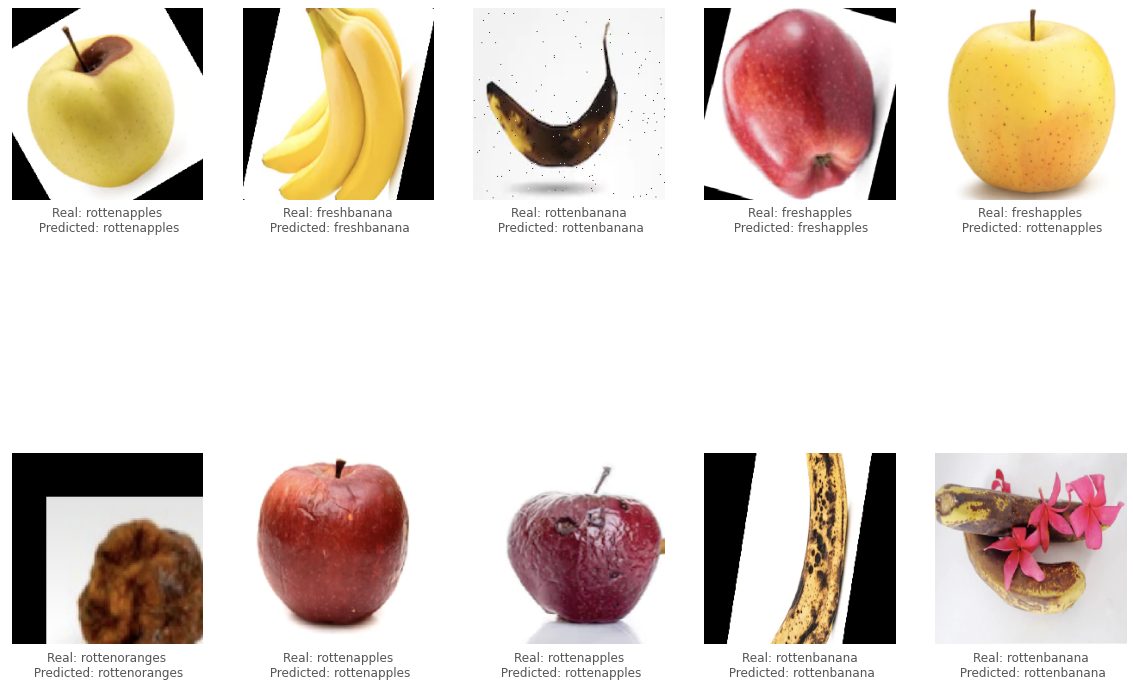

In [12]:
test_images,test_labels=test_gen.next()
plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    real = classes_dict[test_labels[i]]
    img = test_images[i].reshape(1,224,224,3)
    predicted = int(np.argmax(model.predict(img),axis=1))
    predicted = classes_dict[predicted]
    plt.xlabel(f"Real: {real}\n Predicted: {predicted}")

To Be Continued...